In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import shap

In [2]:
pitcher_era_df = pd.read_csv("Resources/full_era_learning.csv")
pitcher_fip_df = pd.read_csv("Resources/full_fip_learning.csv")
pitcher_whip_df = pd.read_csv("Resources/full_whip_learning.csv")


In [3]:
# Import the necessary libraries
from sklearn.impute import SimpleImputer

# Define the imputer with the strategy you want to use (median, mean, etc.)
imputer = SimpleImputer(strategy='median')

# Columns with NaN values in each DataFrame
columns_with_nans_era = pitcher_era_df.columns[pitcher_era_df.isna().any()].tolist()
columns_with_nans_fip = pitcher_fip_df.columns[pitcher_fip_df.isna().any()].tolist()
columns_with_nans_whip = pitcher_whip_df.columns[pitcher_whip_df.isna().any()].tolist()

# Apply the imputation to each DataFrame
pitcher_era_df[columns_with_nans_era] = imputer.fit_transform(pitcher_era_df[columns_with_nans_era])
pitcher_fip_df[columns_with_nans_fip] = imputer.fit_transform(pitcher_fip_df[columns_with_nans_fip])
pitcher_whip_df[columns_with_nans_whip] = imputer.fit_transform(pitcher_whip_df[columns_with_nans_whip])


In [4]:
pitcher_era_df = pitcher_era_df.drop(['Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg'], axis=1)
pitcher_fip_df = pitcher_fip_df.drop(['Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg'], axis=1)
pitcher_whip_df = pitcher_whip_df.drop(['Age Rng','z_score_era_avg', 'z_score_fip_avg', 'z_score_whip_avg'], axis=1)


In [5]:
pitcher_era_df

,Season,Team,Age,W,L,ERA,G,GS,CG,ShO,...,OBP,SLG,wSB,ERA_avg,FIP_avg,WHIP_avg,z_score_era_2023,z_score_diff_era,z_score_fip_2023,z_score_whip_2023
0,2023,KCR,39,1,12,5.530121,22,22,0,0,...,0.0,0.0,0.0,3.381562,3.780352,1.121997,1.072843,0.553782,1.306977,1.045738
1,2023,LAD,35,11,4,2.515528,19,19,0,0,...,0.0,0.0,0.0,2.902238,3.155674,1.012831,0.259911,-0.120401,0.812423,0.718473
2,2023,STL,41,3,9,8.612070,17,17,0,0,...,0.0,0.0,0.0,3.854966,3.989132,1.307504,1.903939,1.247842,1.622344,1.953588
3,2023,BOS,37,2,6,6.264000,9,9,0,0,...,0.0,0.0,0.0,4.213119,3.648284,1.298954,1.270745,0.510974,1.821338,1.377224
4,2023,CHW,36,6,9,6.467967,21,21,0,0,...,0.0,0.0,0.0,4.011502,3.463603,1.283427,1.325748,0.624339,1.331326,1.284064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,2018,BAL,24,0,1,135.000141,1,1,0,0,...,0.0,0.0,0.0,4.271903,4.204399,1.308840,-0.418440,0.041355,-0.527452,-0.566861
838,2018,NYY,23,0,1,5.400000,1,1,0,0,...,0.0,0.0,0.0,4.271903,4.204399,1.308840,-0.418440,0.041355,-0.527452,-0.566861
839,2018,NYM,24,0,0,11.117641,2,2,0,0,...,0.0,0.0,0.0,4.271903,4.204399,1.308840,-0.418440,0.041355,-0.527452,-0.566861
840,2018,MIA,25,1,1,3.441176,7,7,0,0,...,0.0,0.0,0.0,4.271903,4.204399,1.308840,-0.418440,0.041355,-0.527452,-0.566861


In [6]:
def train_and_evaluate_regression_model(df, target_column):
    # Drop rows with missing values
    df.dropna(axis=1, inplace=True)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the XGBoost model
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        max_depth=2,
        learning_rate=0.01,
        n_estimators=500
    )
    
    # Train the XGBoost model
    xgb_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error: {rmse}")
    
    # Create the SHAP explainer
    explainer = shap.Explainer(xgb_model, X_train_scaled)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_scaled, check_additivity=False)
    
    return {
        "rmse": rmse,
        "shap_values": shap_values,
        "X_test_scaled": X_test_scaled,
        "X_train": X_train,
        "X_train_scaled": X_train_scaled,
        "y_pred": y_pred,
        "y_test": y_test
    }

In [7]:
# Apply one-hot encoding to the 'Team' column
pitcher_era_df = pd.get_dummies(pitcher_era_df, columns=['Team'], drop_first=True)
pitcher_fip_df = pd.get_dummies(pitcher_fip_df, columns=['Team'], drop_first=True)
pitcher_whip_df = pd.get_dummies(pitcher_whip_df, columns=['Team'], drop_first=True)


In [8]:
result_era = train_and_evaluate_regression_model(pitcher_era_df, 'z_score_diff_era')


Root Mean Squared Error: 0.3686042985865112


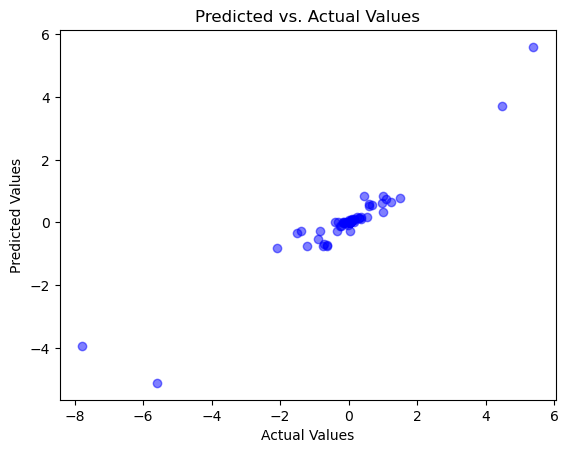

In [10]:
plt.scatter(result_era['y_test'], result_era['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [11]:
result_fip = train_and_evaluate_regression_model(pitcher_fip_df, 'z_score_diff_fip')


Root Mean Squared Error: 0.22205717765970132


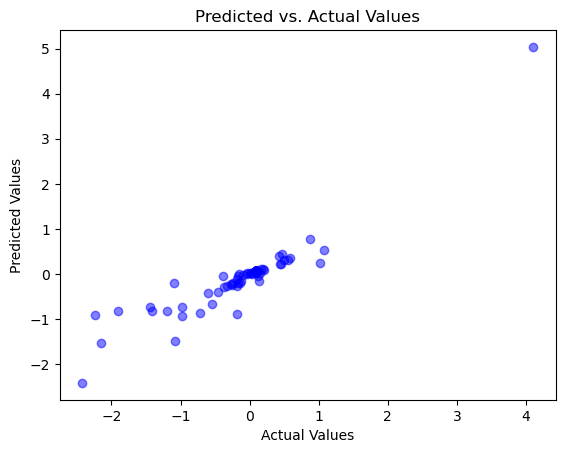

In [12]:
plt.scatter(result_fip['y_test'], result_fip['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [13]:
result_whip = train_and_evaluate_regression_model(pitcher_whip_df, 'z_score_diff_whip')


Root Mean Squared Error: 0.23958635521108912


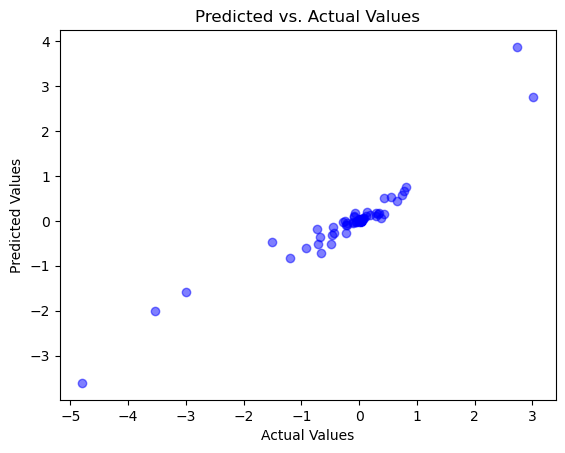

In [14]:
plt.scatter(result_whip['y_test'], result_whip['y_pred'], color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()